# Coexpresion analysis for HBEC IFN experiment

In [359]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [360]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [361]:
data_path = '/data_volume/memento/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [362]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [363]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read 1D HT results

In [364]:
cts = ['C', 'B', 'BC', 'all_ct']
tps = [ '3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [365]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read(data_path + '/binary_test_latest/{}_{}_{}.h5ad'.format(ct, stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [366]:
all_moment = {}
all_ht = {}
for ct in cts:
    all_ht[ct], all_moment[ct] = read_result(ct)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log


In [367]:
tp = '6'
ct = 'all_ct'
for idx, stim in enumerate(stims):
    
    if idx == 0:
        df = all_ht[ct][stim][tp][['gene', 'de_coef', 'de_pval', 'de_fdr']].rename(columns=dict(zip(['de_coef', 'de_pval', 'de_fdr'], ['logfc_'+stim, 'pv_'+stim, 'fdr_'+stim])))
    else:
        a = all_ht[ct][stim][tp][['gene', 'de_coef', 'de_pval', 'de_fdr']].rename(columns=dict(zip(['de_coef', 'de_pval', 'de_fdr'], ['logfc_'+stim, 'pv_'+stim, 'fdr_'+stim])))
        df = df.merge(a, on='gene', how='outer')

### Graph ISG comparisons for each stim

In [368]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [371]:
x.max()

3.2456999872868786

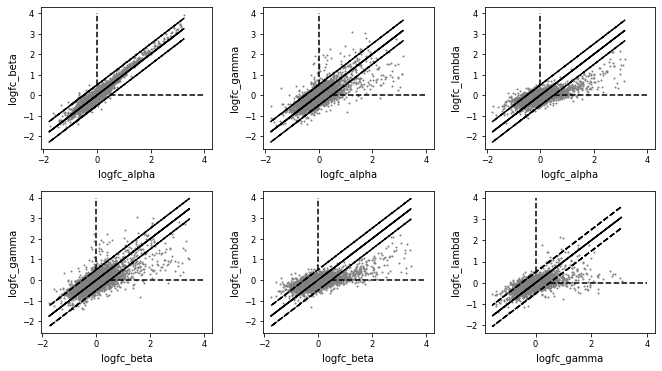

In [372]:
plt.figure(figsize=(11, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
cols = ['logfc_alpha','logfc_beta', 'logfc_gamma', 'logfc_lambda']
for idx, c in enumerate(itertools.combinations(cols,2)):
    
    subset = df[[c[0], c[1]]].copy()
    subset.dropna(inplace=True)

    x, y = subset[c[0]], subset[c[1]]

    plt.subplot(2, 3, idx+1)
    plt.scatter(x, y, s=1, color='grey');
    plt.xlabel(c[0]); plt.ylabel(c[1])
    # plt.plot([-1.5, 3], [-1.5, 3])
    xs = np.arange(0, x.max())
    plt.plot(x,x+0.5, '--', color='k')
    xs = np.arange(0.5, x.max())
    plt.plot(x,x, color='k')
    xs = np.arange(0, x.max()+0.5)
    plt.plot(x,x-0.5, '--', color='k')
    plt.plot([0, 0], [0.5, 4], '--', color='k')
    plt.plot([0.5, 4], [0, 0], '--', color='k')
#     plt.plot([0, 0.5, 0.5], [0.5, 0.5, 0], '--', color='k')

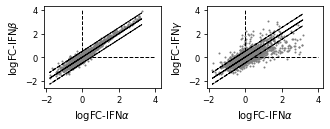

In [388]:
plt.figure(figsize=(5, 1.5))
plt.subplots_adjust(wspace=0.4)
cols = ['logfc_alpha','logfc_beta', 'logfc_gamma', 'logfc_lambda']
for idx, c in enumerate(itertools.combinations(cols,2)):
    
    subset = df[[c[0], c[1]]].copy()
    subset.dropna(inplace=True)

    x, y = subset[c[0]], subset[c[1]]
    plt.subplot(1, 2, idx+1);

    plt.scatter(x, y, s=1, color='grey');
    plt.xlabel(c[0]); plt.ylabel(c[1])
    # plt.plot([-1.5, 3], [-1.5, 3])
    xs = np.arange(0, x.max())
    plt.plot(x,x+0.5, '--', color='k', lw=1)
    xs = np.arange(0.5, x.max())
    plt.plot(x,x, color='k', lw=1)
    xs = np.arange(0, x.max()+0.5)
    plt.plot(x,x-0.5, '--', color='k', lw=1)
    plt.plot([0, 0], [0.5, 4], '--', color='k', lw=1)
    plt.plot([0.5, 4], [0, 0], '--', color='k', lw=1)
    plt.xlabel(r'logFC-IFN$\alpha$')

    if idx == 0:
        plt.ylabel(r'logFC-IFN$\beta$')
    if idx == 1:
        plt.ylabel(r'logFC-IFN$\gamma$')
        break
plt.savefig('stim_lfc_scatter.png', bbox_inches='tight', dpi=500)

### Create long/wide form of HT results

In [12]:
# Create longform data

longform = []
    
for stim in stims:

    for tp in tps:
        a = all_ht['all_ct'][stim][tp]
        a['tp'] = int(tp)
        a['ct'] = 'all_ct'
        a['stim'] = stim
        a['lfc'] = a['de_coef']
        a['fdr'] = a['de_fdr']
        longform.append(a[['gene', 'lfc', 'tp', 'stim', 'fdr']].copy())

longform = pd.concat(longform)


In [221]:
wideform = longform.pivot(index='gene', columns=['stim', 'tp'], values=['lfc', 'fdr'])#.loc[:, 'C'].loc[:, ['control', '']
wideform_fdr = longform.pivot(index='gene', columns=['stim', 'tp'], values=['fdr'])#.loc[:, 'C'].loc[:, ['control', '']
wideform_hr = wideform.xs(6, level='tp', axis=1)

### Define type specific/shared ISGs

In [238]:
isg_types = ['type1', 'type2', 'shared', 'any']
tps = [3, 6, 9, 24, 48]

isg_class_df = pd.DataFrame()
for tp in tps:
    wideform_hr = wideform.xs(tp, level='tp', axis=1)
    for isg_type in isg_types:
        if isg_type == 'type2': # gamma

            type1_both = wideform_hr['lfc'][['alpha', 'beta']].min(axis=1)
            rest = pd.concat([type1_both, wideform_hr['lfc']['lambda']], axis=1).max(axis=1)
            isg_class_df['is_type2_{}'.format(tp)] = (wideform_hr['lfc']['gamma'] > 0.5) & (wideform_hr['lfc']['gamma'] > rest + 0.5) & (wideform_hr['fdr']['gamma'] < 0.05) 

        if isg_type == 'type1':

            type1_both = wideform_hr['lfc'][['alpha', 'beta']].max(axis=1)
            rest = pd.concat([wideform_hr['lfc']['gamma'], wideform_hr['lfc']['lambda']], axis=1).max(axis=1)
            isg_class_df['is_type1_{}'.format(tp)] = (type1_both > 0.5) & (type1_both > rest + 0.5) & ((wideform_hr['fdr']['beta'] < 0.05) | (wideform_hr['fdr']['alpha'] < 0.05))

        if isg_type == 'shared':

            isg_class_df['is_shared_{}'.format(tp)] = (wideform_hr['lfc'][['alpha', 'beta', 'gamma']].min(axis=1) > 0.5) & (wideform_hr['fdr'][['alpha', 'beta', 'gamma']].max(axis=1) < 0.05)
            isg_class_df['is_shared_{}'.format(tp)] = isg_class_df['is_shared_{}'.format(tp)] & ~isg_class_df['is_type1_{}'.format(tp)] & ~isg_class_df['is_type2_{}'.format(tp)]
#         if isg_type == 'any':

#             isg_class_df['is_any_{}'.format(tp)] = (wideform_hr['lfc'][['alpha', 'beta', 'gamma']].max(axis=1) > 0.5) & (wideform_hr['fdr'][['alpha', 'beta', 'gamma']].min(axis=1) < 0.05)


isg_class_df = isg_class_df[isg_class_df.sum(axis=1) > 0].copy()
isg_class_df.to_csv('isg_classes.csv', index=False)

### Consolidate an ISG class for each gene

In [239]:
def classify(row):
    
    t1 = 0
    t2 = 0
    shared = 0
        
    for idx, val in zip(row.index, row):
        
        if 'type1' in idx:
            t1 += val
        elif 'type2' in idx:
            t2 += val
        elif 'shared' in idx:
            shared += val
    if max(t1, t2, shared) == t1:
        return 'type1'
    elif max(t1, t2, shared) == t2:
        return 'type2'
    elif max(t1, t2, shared) == shared:
        return 'shared'
    

In [240]:
isg_class_df['overall_type'] = isg_class_df.apply(classify, axis=1)

In [243]:
isg_class_df.overall_type.value_counts()

type1     477
shared    332
type2     105
Name: overall_type, dtype: int64

### DE gene heatmap

In [285]:
from matplotlib.colors import LinearSegmentedColormap


pal = sns.husl_palette(3, s=.45)
lut = dict(zip(['type1', 'type2', 'shared'], pal))
lut_ind = dict(zip(['type1', 'type2', 'shared'], [-1, 0, 1]))
colors = isg_class_df['overall_type'].map(lut)
colors_ind = isg_class_df['overall_type'].map(lut_ind)

myColors = sns.color_palette('husl')[:3]
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))



In [300]:
heatmap_list = []
for t in ['type1', 'type2', 'shared']:
    heatmap = wideform['lfc'].loc[isg_class_df.query('overall_type == "{}"'.format(t)).index]
    g = sns.clustermap(heatmap.fillna(0.0),cmap='coolwarm', col_cluster=False, metric='euclidean', center=0, vmax=2.5, row_colors=colors)
    inds = g.dendrogram_row.reordered_ind
    plt.close()
    heatmap_list.append(heatmap.iloc[inds])
heatmap = pd.concat(heatmap_list)

sorted_colors = \
    [-1 for i in range(heatmap_list[0].shape[0])] + \
    [0 for i in range(heatmap_list[1].shape[0])] + \
    [1 for i in range(heatmap_list[2].shape[0])]
sorted_colors = pd.DataFrame(sorted_colors)

In [351]:
nan_idx = (np.isnan(heatmap).sum(axis=1) < 2).values

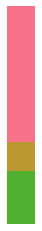

In [355]:
plt.figure(figsize=(0.5,4))

sns.heatmap(sorted_colors.loc[nan_idx], cmap=cmap, yticklabels=False, xticklabels=False,cbar=False)
plt.savefig('de_heatmap_type.pdf', bbox_inches='tight')

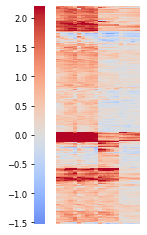

In [357]:
plt.figure(figsize=(2,4))

sns.heatmap(heatmap.loc[nan_idx].fillna(0.0), vmax=2.2, center=0, cmap='coolwarm', yticklabels=False, xticklabels=False, cbar_kws = dict(use_gridspec=False,location="left"))
plt.xlabel(None); plt.ylabel(None)

plt.savefig('de_heatmap.png', bbox_inches='tight')